In [115]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt

In [127]:
%run GpuOptions.ipynb
%run BuildTrainingData.ipynb
%run TrendTools.ipynb

Found 2929 images belonging to 3 classes.
Found 731 images belonging to 3 classes.


In [126]:
shape = (224, 224, 3)
handle_base = 'mobilenet_v2_100_224'
classes = training_data_generator.class_indices

In [ ]:
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=shape),
    hub.KerasLayer(
        f'https://tfhub.dev/google/imagenet/{handle_base}/feature_vector/4',
        trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(
        len(classes), kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
])
model.build(input_shape=(None, *shape))
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.008, momentum=0.7),
    loss=tf.keras.losses.MeanSquaredError(),
    # loss=tf.keras.losses.CategoricalCrossentropy(
    #     from_logits=True, label_smoothing=0.15),
    metrics=['accuracy'])

In [87]:
fit = model.fit(
    training_data_generator,
    epochs=30,
    steps_per_epoch=training_data_generator.samples // 
        training_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.samples // 
        validation_data_generator.batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 91 steps, validate for 22 steps
Epoch 1/15
91/91 [==============================] - 44s 487ms/step - loss: 0.3368 - accuracy: 0.7694 - val_loss: 0.1257 - val_accuracy: 0.8722
Epoch 2/15
91/91 [==============================] - 41s 455ms/step - loss: 0.1589 - accuracy: 0.8723 - val_loss: 0.0889 - val_accuracy: 0.8935
Epoch 3/15
91/91 [==============================] - 41s 451ms/step - loss: 0.1199 - accuracy: 0.8906 - val_loss: 0.0854 - val_accuracy: 0.9048
Epoch 4/15
91/91 [==============================] - 41s 452ms/step - loss: 0.1008 - accuracy: 0.9130 - val_loss: 0.0799 - val_accuracy: 0.8778
Epoch 5/15
91/91 [==============================] - 42s 459ms/step - loss: 0.0870 - accuracy: 0.9192 - val_loss: 0.0836 - val_accuracy: 0.8977
Epoch 6/15
91/91 [==============================] - 43s 467ms/step - loss: 0.0746 - accuracy: 0.9261 - val_loss: 0.0628 - val_accuracy: 0.9162


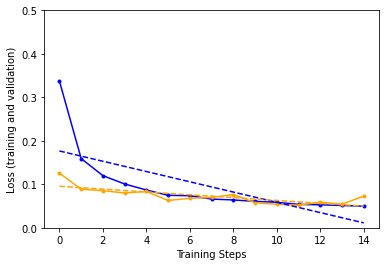

In [129]:
plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0, 0.5])
plt.plot(fit.history['loss'], marker='.', color='blue')
plt.plot(fit.history['val_loss'], marker='.', color='orange')
plt.plot(*linear_trendline(fit.history['loss']), color='blue', linestyle='--')
plt.plot(*linear_trendline(fit.history['val_loss']), color='orange', linestyle='--')
plt.show()

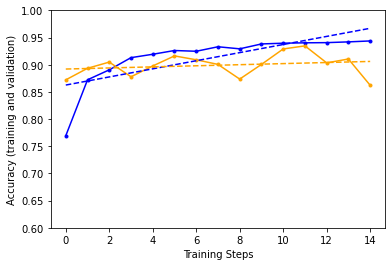

In [131]:
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0.6, 1])
plt.plot(fit.history['accuracy'], marker='.', color='blue')
plt.plot(fit.history['val_accuracy'], marker='.', color='orange')
plt.plot(*linear_trendline(fit.history['accuracy']), color='blue', linestyle='--')
plt.plot(*linear_trendline(fit.history['val_accuracy']), color='orange', linestyle='--')
plt.show()